In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# GP regresion with Guy

In [2]:
npts = 10 # 10 to keep computation time reasonable
x = np.sort(np.random.randn(npts)) * 2.3 + 0.8 # make it look reasonably like our stellar data


In [3]:
def func(x): 
    return np.poly1d([0.2, 1.0, 0.5])(x)  
# a polynomial and a straight line fit

In [4]:
y_true = func(x)
y_err = np.ones_like(x) * 0.2
y_obs = y_true + np.random.randn(npts) * y_err

<ErrorbarContainer object of 3 artists>

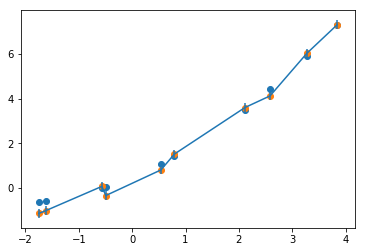

In [5]:
fig, ax = plt.subplots()
ax.scatter(x, y_true)
ax.scatter(x, y_obs)
ax.errorbar(x, y_obs, yerr=y_err, linestyle=None)

In [6]:
model = pm.Model()
with model:
    # y = m*x + c
    m = pm.Normal('m', 0, 1e3)
    c = pm.Normal('c', 0, 1e3)
    
    fit = pm.Deterministic('fit', m*x+c)
    
    # what we expect to see:
    obs = pm.Normal('obs', fit, y_err, observed=y_obs)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, m]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3979.52draws/s]
The acceptance probability does not match the target. It is 0.8834558135596933, but should be close to 0.8. Try to increase the number of tuning steps.


In [7]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,1.467,0.033,1.402,1.526,0.001,0.001,1203.0,1203.0,1211.0,1348.0,1.0
c,0.815,0.071,0.684,0.949,0.002,0.001,1325.0,1315.0,1329.0,1092.0,1.0
fit[0],-1.752,0.110,-1.965,-1.550,0.003,0.002,1202.0,1202.0,1203.0,1175.0,1.0
fit[1],-1.560,0.107,-1.764,-1.361,0.003,0.002,1206.0,1206.0,1209.0,1173.0,1.0
fit[2],-0.016,0.082,-0.163,0.136,0.002,0.002,1254.0,1058.0,1259.0,1071.0,1.0
fit[3],0.092,0.080,-0.065,0.229,0.002,0.002,1260.0,1128.0,1268.0,1072.0,1.0
fit[4],1.606,0.066,1.485,1.730,0.002,0.001,1421.0,1411.0,1430.0,1202.0,1.0
fit[5],1.978,0.064,1.863,2.104,0.002,0.001,1481.0,1476.0,1483.0,1258.0,1.0
fit[6],3.917,0.075,3.782,4.061,0.002,0.001,1791.0,1787.0,1792.0,1457.0,1.0
fit[7],4.604,0.084,4.439,4.753,0.002,0.001,1792.0,1789.0,1764.0,1346.0,1.0


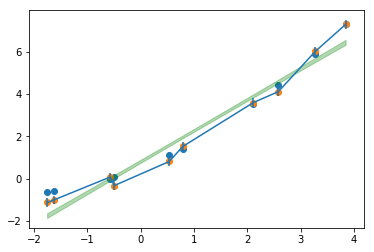

In [8]:
fig, ax = plt.subplots()
ax.scatter(x, y_true)
ax.scatter(x, y_obs)
ax.errorbar(x, y_obs, yerr=y_err, linestyle=None)

# have a look at the fit vs the data
mean = np.mean(trace['fit'], axis=0)
std = np.std(trace['fit'], axis=0)

ax.fill_between(x, mean-std, mean+std, alpha=0.3, color='g')

In [9]:
model_gp = pm.Model()
X = x[:, None]

with model_gp:
    # now with a GP and some priors
    m = pm.Normal('m', 0, 1e3)
    c = pm.Normal('c', 0, 1e3)
    
    cov_func = pm.gp.cov.ExpQuad(1, ls = 1.0) # this is the squared exponential covariance function
    gp = pm.gp.Latent(cov_func=cov_func) # makes the mean function 0
    
    f = gp.prior('f', X=X) # produces some x drawn from the GP
    
    fit = pm.Deterministic('fit', m*x + c + f)
    
    # what we expect to see:
    obs = pm.Normal('obs', fit, y_err, observed=y_obs)
    
    trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, c, m]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 441.23draws/s]


In [15]:
pm.summary(trace, var_names=["m", "c"])

/home/lindsey/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:297: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,1.508,0.249,1.049,1.969,0.007,0.005,1246.0,1246.0,1259.0,1244.0,1.00
c,0.924,0.639,-0.339,2.040,0.018,0.013,1252.0,1218.0,1258.0,1520.0,1.01


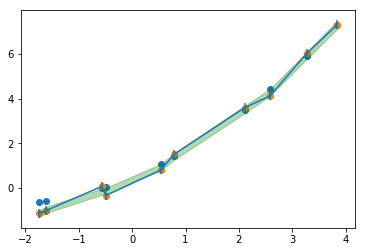

In [11]:
fig, ax = plt.subplots()
ax.scatter(x, y_true)
ax.scatter(x, y_obs)
ax.errorbar(x, y_obs, yerr=y_err, linestyle=None)

mean = np.mean(trace['fit'], axis=0)
std = np.std(trace['fit'], axis=0)

ax.fill_between(x, mean-std, mean+std, alpha=0.3, color='g')

In [12]:
X_new = np.linspace(-8, 8, 50)[:, None]

with model_gp:
    f_new = gp.conditional('f_new', X_new)
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_new, fit], samples=1000)

/home/lindsey/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:13<00:00, 75.18it/s]


Text(0, 0.5, '$\\mathcal{GP}$ contribution')

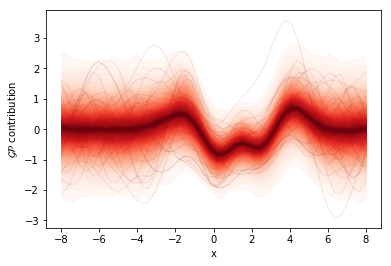

In [13]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots()
plot_gp_dist(ax, pred_samples['f_new'], X_new);
ax.set_xlabel('x')
ax.set_ylabel(r'$\mathcal{GP}$ contribution')

sigma - variation we're willing to accept; can have a tight prior, not gonna have huge mHz variation on dNu for example